### 입력 데이터 전처리

In [ ]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta


nc_data_path = "../ENSEMBLE_MODEL_CROP_DATA"
json_path = "../target_metadata.json"
with open(json_path, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

target_date = metadata["target_date"]  # ex) "2025013100"
target_datetime = datetime.strptime(target_date, "%Y%m%d%H")

# 10일 전 00시부터 target_date 00시까지의 날짜 리스트 생성
start_date = target_datetime - timedelta(days=10)  # 10일 전
start_date = start_date.replace(hour=0)  # 00시 기준으로 맞추기
date_list = [(start_date + timedelta(hours=12 * i)).strftime("%Y%m%d%H") 
             for i in range(((target_datetime - start_date).days * 2) + 1)]  # 12시간 간격

print(f"📅 분석할 날짜 리스트: {date_list}")


📅 분석할 날짜 리스트: ['2025012000', '2025012012', '2025012100', '2025012112', '2025012200', '2025012212', '2025012300', '2025012312', '2025012400', '2025012412', '2025012500', '2025012512', '2025012600', '2025012612', '2025012700', '2025012712', '2025012800', '2025012812', '2025012900', '2025012912', '2025013000']


In [ ]:
# 데이터 저장용 리스트
datasets = []

for date in date_list:
    nc_file = os.path.join(nc_data_path, f"cropped_{date}.nc")
    
    if os.path.exists(nc_file):
        print(f"📂 파일 로드 중: {nc_file}")
        ds = xr.open_dataset(nc_file)
        datasets.append(ds)
    else:
        print(f"⚠️ 파일 없음: {nc_file}")

# 첫 번째 파일의 구조 확인
if datasets:
    print(datasets[0])  # NetCDF 구조 출력


📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012000.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012012.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012100.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012112.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012200.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012212.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012300.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012312.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012400.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012412.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012500.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012512.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012600.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012612.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012700.nc
📂 파일 로드 중: ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012712.nc
📂 파일 로드 중: ../ENSEMBLE_M

In [ ]:
# 위도 & 경도 좌표 확인
latitudes = datasets[0].latitude.values
longitudes = datasets[0].longitude.values

print(f"📌 위도 범위: {latitudes.min()} ~ {latitudes.max()} ({len(latitudes)}개)")
print(f"📌 경도 범위: {longitudes.min()} ~ {longitudes.max()} ({len(longitudes)}개)")

📌 위도 범위: 32.400001525878906 ~ 34.900001525878906 (26개)
📌 경도 범위: 125.0 ~ 128.10000610351562 (32개)


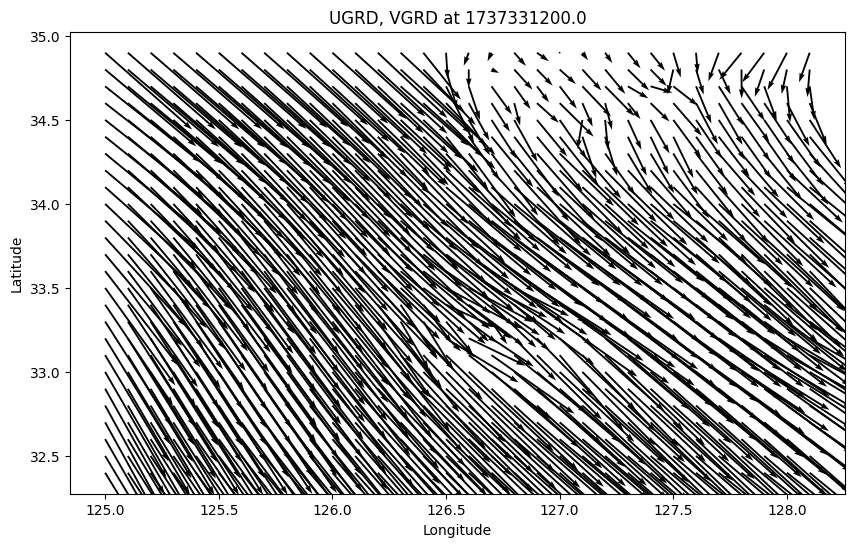

In [119]:
import matplotlib.pyplot as plt

# ✅ 특정 날짜 선택
sample_ds = datasets[0]

# ✅ 특정 시간 선택 (첫 번째 시간 스텝)
time_index = 0
ugrd = sample_ds.UGRD_10maboveground.isel(time=time_index)
vgrd = sample_ds.VGRD_10maboveground.isel(time=time_index)

# ✅ 벡터 필드 그리기
plt.figure(figsize=(10, 6))
plt.quiver(sample_ds.longitude, sample_ds.latitude, ugrd, vgrd, scale=50)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"UGRD, VGRD at {sample_ds.time.values[time_index]}")
plt.show()

### 3차원 -> 2차원 데이터 변환

In [ ]:
import os
import xarray as xr
import json
from datetime import datetime, timedelta

# ✅ 실행 경로 설정
base_path = "../"
nc_data_path = os.path.join(base_path, "ENSEMBLE_MODEL_CROP_DATA")  # NC 파일 경로
obs_data_path = os.path.join(base_path, "OBS_DATA_UV")  # 관측 데이터 경로
meta_data_path = os.path.join(base_path, "SAR_meta_data.csv")  # 관측소 메타데이터
json_path = os.path.join(base_path, "target_metadata.json")  # JSON 경로

with open(json_path, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

station_num = str(metadata["station_num"])  # 관측소 번호

# 관측소 메타데이터 로드
meta_df = pd.read_csv(meta_data_path, encoding="cp949")
meta_df["stn_num"] = meta_df["stn_num"].astype(str) 
station_info = meta_df[meta_df["stn_num"] == station_num]

if not station_info.empty:
    station_lat = station_info["lat"].values[0]
    station_lon = station_info["lon"].values[0]
    print(f"{station_num}의 관측소 위치: 위도 {station_lat}, 경도 {station_lon}")
else:
    raise ValueError(f"⚠️ 관측소 {station_num}의 메타데이터를 찾을 수 없습니다.")


samples = {}
nc_files = sorted([f for f in os.listdir(nc_data_path) if f.startswith("cropped_") and f.endswith(".nc")])

# NC 파일 개수만큼 샘플 생성
for sample_idx, nc_file in enumerate(nc_files):
    forecast_path = os.path.join(nc_data_path, nc_file)
    forecast_time_str = nc_file.split("_")[-1].split(".")[0]  # YYYYMMDDHH 추출
    forecast_datetime = datetime.strptime(forecast_time_str, "%Y%m%d%H")

    print(f"📂 {forecast_path} 처리 중...")

    # 예측 데이터 로드
    ds = xr.open_dataset(forecast_path)
    df_forecast = ds.to_dataframe().reset_index()

    df_forecast = df_forecast[['time', 'latitude', 'longitude', 'UGRD_10maboveground', 'VGRD_10maboveground']]

    # time 값을 datetime 형식으로 변환하고 가장 가까운 정시로 변환
    df_forecast["time"] = pd.to_datetime(df_forecast["time"], unit="s")
    df_forecast["time"] = df_forecast["time"].dt.round("H")

    # 3시간 간격 유지
    df_forecast = df_forecast[df_forecast["time"].dt.hour % 3 == 0]

    # 관측 데이터 로드
    obs_file = [f for f in os.listdir(obs_data_path) if f.endswith(f"_{station_num}.csv")]

    if obs_file:
        obs_file_path = os.path.join(obs_data_path, obs_file[0])
        df_obs = pd.read_csv(obs_file_path)
        df_obs["model_fct"] = pd.to_datetime(df_obs["model_fct"], errors="coerce")

        # 관측 데이터: 해당날 00시 ~ 다음날 00시까지 포함
        obs_start = forecast_datetime
        obs_end = forecast_datetime + timedelta(days=1)
        df_obs = df_obs[(df_obs["model_fct"] >= obs_start) & (df_obs["model_fct"] <= obs_end)]

        # 1시간 간격 리샘플링 후 3시간 간격 유지
        df_obs.set_index("model_fct", inplace=True)
        df_obs = df_obs.resample("1H").asfreq()

        # 결측치 처리 (obs_u, obs_v의 전체 평균값으로 보간)
        obs_u_mean = df_obs["obs_u"].mean()
        obs_v_mean = df_obs["obs_v"].mean()

        df_obs["obs_u"] = df_obs["obs_u"].interpolate(method="linear").fillna(obs_u_mean)
        df_obs["obs_v"] = df_obs["obs_v"].interpolate(method="linear").fillna(obs_v_mean)

        # 3시간 간격으로 샘플링
        df_obs = df_obs.resample("3H").asfreq()

        # 인덱스 컬럼으로 재설정
        df_obs.reset_index(inplace=True)

        # 관측소 위도, 경도 추가
        df_obs["latitude"] = station_lat
        df_obs["longitude"] = station_lon

        print(f"✅ {station_num}의 관측 데이터 결측치 채움 완료 (평균 U: {obs_u_mean:.3f}, 평균 V: {obs_v_mean:.3f})")
    else:
        df_obs = None
        print(f"⚠️ 관측 데이터 없음: {station_num}")

    # obs_ws, obs_wd 제거
    if df_obs is not None:
        df_obs = df_obs.drop(columns=['obs_ws', 'obs_wd'], errors='ignore')

    # 샘플 저장 (각 nc 파일별로 1개의 샘플 생성)
    samples[sample_idx] = {
        "forecast": df_forecast,
        "obs": df_obs
    }


✅ KG_0028의 관측소 위치: 위도 33.7, 경도 126.59
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012000.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 5.220, 평균 V: -3.960)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012012.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 3.894, 평균 V: -5.016)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012100.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 2.902, 평균 V: -4.025)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012112.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 1.862, 평균 V: -2.874)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012200.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 0.034, 평균 V: -2.194)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012212.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: -0.334, 평균 V: -2.177)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012300.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: -0.009, 평균 V: -2.434)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012312.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: -1.508, 평균 V: -2.940)
📂 ../ENSEMBLE_MODEL_CROP_DATA\c

C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_forecast["time"] = df_forecast["time"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("1H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("3H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_forecast["time"] = df_forecast["time"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:76: FutureWarning: 'H' is deprecated and will be removed in a future ver

✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 7.906, 평균 V: -7.035)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025012912.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 4.143, 평균 V: -4.298)
📂 ../ENSEMBLE_MODEL_CROP_DATA\cropped_2025013000.nc 처리 중...
✅ KG_0028의 관측 데이터 결측치 채움 완료 (평균 U: 0.425, 평균 V: -0.901)

🟢 샘플 0
🔹 예측 데이터 (3시간 간격 유지, 해당날 00~다음날 00시):
                 time   latitude  longitude  UGRD_10maboveground  \
0 2025-01-20 00:00:00  32.400002      125.0             3.704649   
1 2025-01-20 03:00:00  32.400002      125.0             3.500380   
2 2025-01-20 06:00:00  32.400002      125.0             5.115825   
3 2025-01-20 09:00:00  32.400002      125.0             5.428569   
4 2025-01-20 12:00:00  32.400002      125.0             3.612476   

   VGRD_10maboveground  
0            -6.067770  
1            -6.015373  
2            -5.924464  
3            -5.652524  
4            -6.396767  

🔹 관측 데이터 (3시간 간격 유지, 해당날 00~다음날 00시, 위경도 추가됨):
            model_fct     obs_u     obs_v  latitude  longit

C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_forecast["time"] = df_forecast["time"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:76: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("1H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("3H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_forecast["time"] = df_forecast["time"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\1082928825.py:76: FutureWarning: 'H' is deprecated and will be removed in a future ver

In [ ]:
# 개별 샘플 확인
for key, value in samples.items():
    print(f"\n🟢 샘플 {key}")
    print("🔹 예측 데이터 (3시간 간격 유지, 해당날 00~다음날 00시):")
    print(value["forecast"].head() if value["forecast"] is not None else "❌ 없음")
    print("\n🔹 관측 데이터 (3시간 간격 유지, 해당날 00~다음날 00시, 위경도 추가됨):")
    print(value["obs"].head() if value["obs"] is not None else "❌ 없음")

In [176]:
len(samples)

21

In [177]:
samples.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [178]:
samples[0]

{'forecast':                      time   latitude   longitude  UGRD_10maboveground  \
 0     2025-01-20 00:00:00  32.400002  125.000000             3.704649   
 1     2025-01-20 03:00:00  32.400002  125.000000             3.500380   
 2     2025-01-20 06:00:00  32.400002  125.000000             5.115825   
 3     2025-01-20 09:00:00  32.400002  125.000000             5.428569   
 4     2025-01-20 12:00:00  32.400002  125.000000             3.612476   
 ...                   ...        ...         ...                  ...   
 20795 2025-01-22 12:00:00  34.900002  128.100006             1.858490   
 20796 2025-01-22 15:00:00  34.900002  128.100006             0.472796   
 20797 2025-01-22 18:00:00  34.900002  128.100006            -1.745306   
 20798 2025-01-22 21:00:00  34.900002  128.100006            -0.370198   
 20799 2025-01-23 00:00:00  34.900002  128.100006            -0.992759   
 
        VGRD_10maboveground  
 0                -6.067770  
 1                -6.015373  
 2      

In [ ]:
df_forecast_20 = samples[20]["forecast"]  
print("📌 예측 데이터 (Forecast) 미리보기:")
df_forecast_20.head()  


📌 예측 데이터 (Forecast) 미리보기:


,time,latitude,longitude,UGRD_10maboveground,VGRD_10maboveground
0,2025-01-30 00:00:00,32.400002,125.0,-2.291521,-0.007360
1,2025-01-30 03:00:00,32.400002,125.0,-2.658121,1.517325
2,2025-01-30 06:00:00,32.400002,125.0,-2.738321,2.767698
3,2025-01-30 09:00:00,32.400002,125.0,-2.843219,3.902555
4,2025-01-30 12:00:00,32.400002,125.0,-3.123942,4.927009


In [180]:
df_forecast_20.shape

(20800, 5)

In [181]:
df_forecast_20.tail()

,time,latitude,longitude,UGRD_10maboveground,VGRD_10maboveground
20795,2025-02-01 12:00:00,34.900002,128.100006,-2.577039,-5.254018
20796,2025-02-01 15:00:00,34.900002,128.100006,-0.223511,-3.780316
20797,2025-02-01 18:00:00,34.900002,128.100006,-1.570834,-8.577523
20798,2025-02-01 21:00:00,34.900002,128.100006,-1.192828,-4.777678
20799,2025-02-02 00:00:00,34.900002,128.100006,-1.017357,-4.433875


In [ ]:
df_obs_20 = samples[0]["obs"]  
print("\n📌 관측 데이터 (Observation) 미리보기:")
df_obs_20.head() 


📌 관측 데이터 (Observation) 미리보기:


,model_fct,obs_u,obs_v,latitude,longitude
0,2025-01-20 00:00:00,5.149394,-0.723700,33.7,126.59
1,2025-01-20 03:00:00,5.578560,-1.920852,33.7,126.59
2,2025-01-20 06:00:00,6.443534,-2.735118,33.7,126.59
3,2025-01-20 09:00:00,5.242573,-3.670889,33.7,126.59
4,2025-01-20 12:00:00,4.806866,-3.755535,33.7,126.59


In [ ]:
df_obs_20


📌 변환된 관측 데이터 (Observation) 미리보기:


,model_fct,obs_u,obs_v,latitude,longitude
0,2025-01-20 00:00:00,5.149394,-0.723700,33.7,126.59
1,2025-01-20 03:00:00,5.578560,-1.920852,33.7,126.59
2,2025-01-20 06:00:00,6.443534,-2.735118,33.7,126.59
3,2025-01-20 09:00:00,5.242573,-3.670889,33.7,126.59
4,2025-01-20 12:00:00,4.806866,-3.755535,33.7,126.59
5,2025-01-20 15:00:00,6.343038,-3.811282,33.7,126.59
6,2025-01-20 18:00:00,5.777694,-5.387787,33.7,126.59
7,2025-01-20 21:00:00,3.914289,-6.514471,33.7,126.59
8,2025-01-21 00:00:00,3.127375,-6.706678,33.7,126.59


### 2D CNN을 위한 데이터 전처리

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class WindDataset(Dataset):
    def __init__(self, samples):
        self.data = []
        self.labels = []
        
        for sample_key in samples.keys():
            df_forecast = samples[sample_key]["forecast"]
            df_obs = samples[sample_key]["obs"]

            if df_forecast is None or df_obs is None:
                continue  
            
            # 시간 정리
            df_forecast["time"] = pd.to_datetime(df_forecast["time"])
            df_obs["model_fct"] = pd.to_datetime(df_obs["model_fct"])
            
            # 중복 제거 (시간-위도-경도 조합)
            df_forecast = df_forecast.groupby(["time", "latitude", "longitude"]).mean().reset_index()

            # 시간 정규화
            df_forecast["hour"] = df_forecast["time"].dt.hour / 24.0  # 0~1 범위

            # 좌표 정보 정규화
            df_forecast["latitude"] = (df_forecast["latitude"] - df_forecast["latitude"].min()) / (df_forecast["latitude"].max() - df_forecast["latitude"].min())
            df_forecast["longitude"] = (df_forecast["longitude"] - df_forecast["longitude"].min()) / (df_forecast["longitude"].max() - df_forecast["longitude"].min())

            # 2D Grid 변환 (시간 × 공간)
            grid_data = df_forecast.pivot(index="time", columns=["latitude", "longitude"], values=["UGRD_10maboveground", "VGRD_10maboveground", "hour"])
            grid_data = grid_data.fillna(0).values  # 결측치 처리

            # 🔹 **Grid 데이터를 3D 형태로 변환** (시간, 공간, 변수)
            time_steps = len(df_forecast["time"].unique())  # 시간 개수
            grid_data = grid_data.reshape(time_steps, -1, 3)  # (시간, 공간, 변수)

            # 관측 데이터 추출 (특정 지점의 값)
            obs_u = df_obs["obs_u"].mean()
            obs_v = df_obs["obs_v"].mean()

            # 모든 위치에서 같은 값으로 obs_u, obs_v 추가
            obs_u_grid = np.full((time_steps, grid_data.shape[1]), obs_u)  # 시간 × 공간
            obs_v_grid = np.full((time_steps, grid_data.shape[1]), obs_v)  # 시간 × 공간

            # 🔹 **obs_u, obs_v도 3D로 변환**
            obs_u_grid = obs_u_grid[..., np.newaxis]  # (시간, 공간, 1)
            obs_v_grid = obs_v_grid[..., np.newaxis]  # (시간, 공간, 1)

            # 최종 입력 데이터 (UGRD, VGRD, hour, obs_u, obs_v 포함)
            X_sample = np.concatenate([grid_data, obs_u_grid, obs_v_grid], axis=-1)  # (시간, 공간, 5)

            self.data.append(torch.tensor(X_sample, dtype=torch.float32))
            self.labels.append(torch.tensor([obs_u, obs_v], dtype=torch.float32))  # 정답값

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


dataset = WindDataset(samples)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

print(f"데이터 로드 완료! 총 {len(dataset)}개 샘플")


✅ 데이터 로드 완료! 총 21개 샘플


In [187]:
dataset[0]

(tensor([[[ 3.7046,  3.9269,  4.0945,  5.1537, -3.9140],
          [ 4.2843,  4.4336,  4.6168,  5.1537, -3.9140],
          [ 4.7757,  4.8841,  4.9945,  5.1537, -3.9140],
          ...,
          [ 0.0000,  0.0000,  0.0000,  5.1537, -3.9140],
          [ 0.0000,  0.0000,  0.0000,  5.1537, -3.9140],
          [ 0.0000,  0.0000,  0.0000,  5.1537, -3.9140]],
 
         [[ 3.5004,  3.6135,  3.7043,  5.1537, -3.9140],
          [ 3.8050,  3.8860,  3.9863,  5.1537, -3.9140],
          [ 4.0513,  4.0832,  4.1116,  5.1537, -3.9140],
          ...,
          [ 0.1250,  0.1250,  0.1250,  5.1537, -3.9140],
          [ 0.1250,  0.1250,  0.1250,  5.1537, -3.9140],
          [ 0.1250,  0.1250,  0.1250,  5.1537, -3.9140]],
 
         [[ 5.1158,  5.2146,  5.2797,  5.1537, -3.9140],
          [ 5.3366,  5.3843,  5.4488,  5.1537, -3.9140],
          [ 5.4780,  5.4683,  5.4188,  5.1537, -3.9140],
          ...,
          [ 0.2500,  0.2500,  0.2500,  5.1537, -3.9140],
          [ 0.2500,  0.2500,  0.2500,

### 출력 데이터셋 전처리 

In [ ]:

labels = {}

# 날짜별로 24~48시간 후의 관측 데이터를 정답(label)로 저장
for sample_idx, forecast_time_str in enumerate(datelist):
    forecast_datetime = datetime.strptime(forecast_time_str, "%Y%m%d%H")
    next_day_start = forecast_datetime + timedelta(hours=24)  # 24시간 후
    next_day_end = forecast_datetime + timedelta(hours=48)  # 48시간 후

    # 관측 데이터 불러오기
    obs_file = [f for f in os.listdir(obs_data_path) if f.endswith(f"_{station_num}.csv")]

    if obs_file:
        obs_file_path = os.path.join(obs_data_path, obs_file[0])
        df_obs = pd.read_csv(obs_file_path)
        df_obs["model_fct"] = pd.to_datetime(df_obs["model_fct"], errors="coerce")

        # 3시간 간격 유지 & 24~48시간 뒤까지 데이터 선택
        df_obs = df_obs[(df_obs["model_fct"] >= next_day_start) & (df_obs["model_fct"] <= next_day_end)]
        df_obs.set_index("model_fct", inplace=True)
        df_obs = df_obs.resample("3H").asfreq()

        # 결측값 처리
        obs_u_mean = df_obs["obs_u"].mean()
        obs_v_mean = df_obs["obs_v"].mean()
        df_obs["obs_u"] = df_obs["obs_u"].interpolate(method="linear").fillna(obs_u_mean)
        df_obs["obs_v"] = df_obs["obs_v"].interpolate(method="linear").fillna(obs_v_mean)

        # obs_ws, obs_wd 제거
        df_obs = df_obs.drop(columns=["obs_ws", "obs_wd"], errors="ignore")

        # 정답 데이터 저장
        labels[sample_idx] = df_obs.reset_index()
        print(f"✅ 샘플 {sample_idx}: 24~48시간 후 관측 데이터 생성 완료")
    else:
        labels[sample_idx] = None
        print(f"⚠️ 관측 데이터 없음: 샘플 {sample_idx}")


✅ 샘플 0: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 1: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 2: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 3: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 4: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 5: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 6: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 7: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 8: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 9: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 10: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 11: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 12: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 13: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 14: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 15: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 16: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 17: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 18: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 19: 24~48시간 후 관측 데이터 생성 완료
✅ 샘플 20: 24~48시간 후 관측 데이터 생성 완료

🟢 샘플 0 (24~48시간 후 정답)
            model_fct     obs_u     obs_v
0 2025-01-21 00:00:00  3.127375 -6.706678
1 2025-01-21 03:00:00  2.704757 -5.800370
2 2025-01-21 06:00:00  2.359073 -5.298564
3 2025-01-21 09:00:00  2.907803 -4.310995
4 2025-01-21 12:00:00  3.011088 -3.344152

🟢 샘플 1 (24~48시간 후 정답)
            model_fct     obs_u     obs_

C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\2755678679.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("3H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\2755678679.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("3H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\2755678679.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("3H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\2755678679.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_obs = df_obs.resample("3H").asfreq()
C:\Users\dasap\AppData\Local\Temp\ipykernel_38424\2755678679.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  

In [ ]:
for key, value in labels.items():
    print(f"\n🟢 샘플 {key} (24~48시간 후 정답)")
    print(value.head() if value is not None else "❌ 없음")

In [194]:
len(labels)

21

In [195]:
labels[0]

,model_fct,obs_u,obs_v
0,2025-01-21 00:00:00,3.127375,-6.706678
1,2025-01-21 03:00:00,2.704757,-5.800370
2,2025-01-21 06:00:00,2.359073,-5.298564
3,2025-01-21 09:00:00,2.907803,-4.310995
4,2025-01-21 12:00:00,3.011088,-3.344152
5,2025-01-21 15:00:00,4.109486,-2.668731
6,2025-01-21 18:00:00,3.263006,-4.176457
7,2025-01-21 21:00:00,2.475783,-2.749636
8,2025-01-22 00:00:00,1.811303,-1.574542
